<a href="https://colab.research.google.com/github/cmagganas/DTSA-5301-Data-Science-as-a-Field/blob/main/Final-Project-2/2020_US_COVID_mortality_by_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2020 US COVID-19 Mortality Rate Health Factor Analysis

[DOWNLOAD 2020 County Health Data CSV](https://www.countyhealthrankings.org/sites/default/files/media/document/analytic_data2020_0.csv)

[source: countyhealthrankings.org](https://www.countyhealthrankings.org/explore-health-rankings/rankings-data-documentation)

[Interactive Map of Health Index by US county](https://www.bcbs.com/the-health-of-america/health-index/national-health-index)

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [ ]:
# load COVID data
url_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
UScases = pd.read_csv(url_path+'time_series_covid19_confirmed_US.csv')
USdeaths = pd.read_csv(url_path+'time_series_covid19_deaths_US.csv')

# change stateID to int type
UScases.FIPS = UScases['FIPS'].astype('Int64')
USdeaths.FIPS = USdeaths['FIPS'].astype('Int64')

# derive mortatlity rate
mortality_rate_2020 = USdeaths['1/1/21'] / UScases['1/1/21']
mortality_rate_2021 = (USdeaths['1/1/22'] - USdeaths['1/1/21']) / (UScases['1/1/22'] - UScases['1/1/21']) # not used
US = USdeaths[['FIPS', 'Admin2', 'Province_State','Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population']].dropna()
US['mortality_rate'] = mortality_rate_2020
US.dropna(inplace=True)
US.rename(columns={'Admin2': 'County', 'Province_State': 'State', 'Long_': 'Long'}, inplace=True)

# load health data
df = pd.read_csv('https://raw.githubusercontent.com/cmagganas/DTSA-5301-Data-Science-as-a-Field/main/analytic_data2020_0.csv')
oldCols = {df[col][0]:col for col in df.columns}
df.columns = df.iloc[0]
df.drop([0], inplace=True)

# merge, drop columns with too many nan values (less than 10%), use state mean to impute others
USmerge = US.merge(df, left_on='FIPS', right_on='fipscode')
USmerge = USmerge.loc[:,USmerge.isnull().mean().values < 0.10]
USmerge.fillna(USmerge.groupby('State').transform('mean'), inplace=True)
USmerge2train = USmerge[[col for col in USmerge if col.endswith('_rawvalue')]]
USmerge2train.dropna(axis=1, inplace=True)

In [ ]:
# train RandomForest
X = pd.DataFrame(USmerge2train, columns=USmerge2train.columns)
y = USmerge.mortality_rate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, y_train)

Text(0.5, 0, 'Feature Importance')

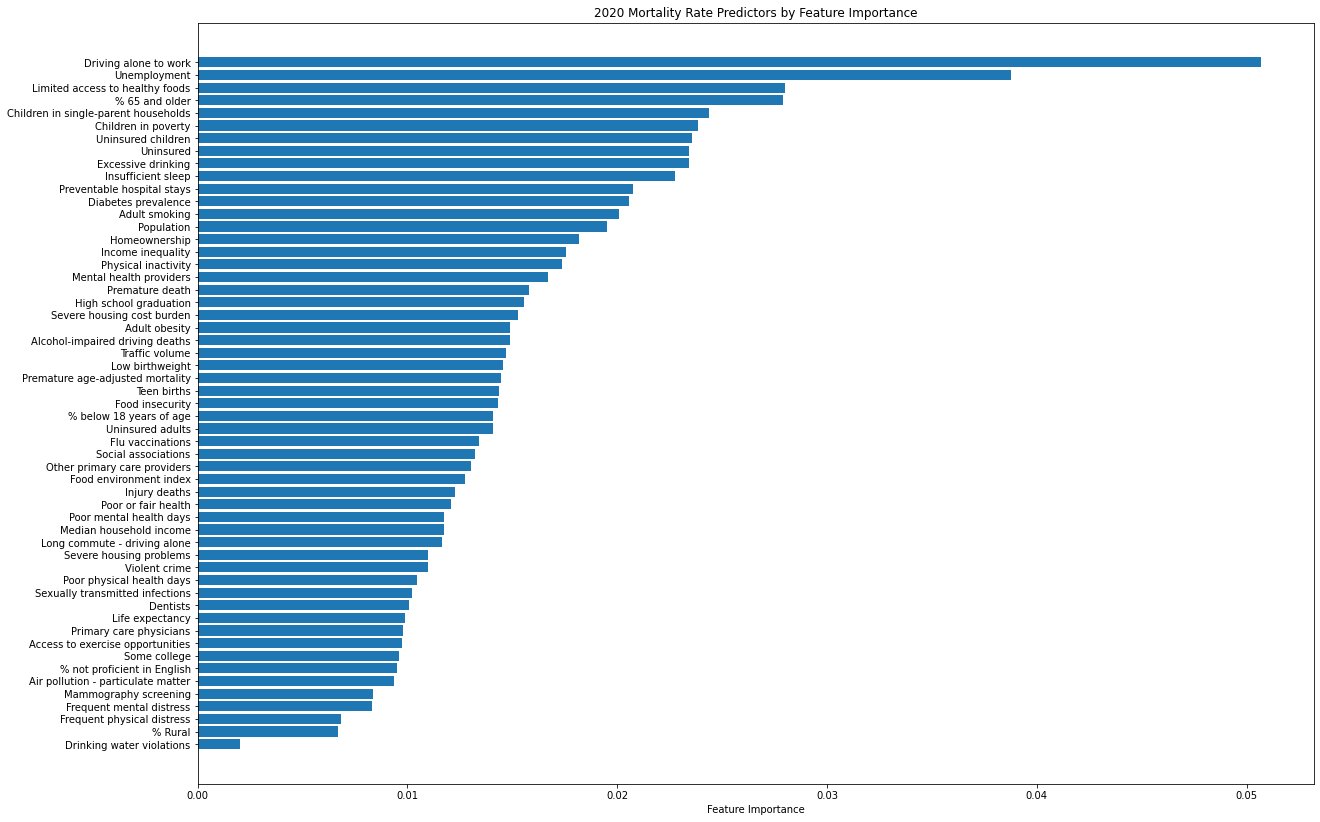

In [4]:
# sort columns by feature importance i.e. which features are the best predictors of COVID mortality rate
sort = rf.feature_importances_.argsort()
oldColSorted = [oldCols[k].replace(' raw value', '') for k in USmerge2train.columns[sort]]

# drop columns with racial and gender data as predictors
bias_list = ['asian','black','female','hawaiian','hispanic','indian'] # only those appearing in feature set
filter_index = [idx for idx,ele in enumerate(oldColSorted) if all(x not in ele.lower() for x in bias_list)]
oldColSorted = [oldColSorted[i] for i in filter_index]
sort = [i for i in sort if i in filter_index]

# plot
plt.figure(figsize=(20,14))
plt.barh(oldColSorted, rf.feature_importances_[sort])
plt.title("2020 Mortality Rate Predictors by Feature Importance")
plt.xlabel("Feature Importance")